written by: Nutchaya Phumekham, July, 2022

### This notebook contains an explaination of each steps of CRAB data analysis. It focuses on how to read raw data from HDFS and process them in SWAN environment. It also contains the detailed explaination of some ready-to-use functions to make data analysis more convenient.

#### Important Note:  To use the functions below, save file [utils.py](https://github.com/nutty7fold/cern-crab-data-analysis/blob/main/crab_data_analysis_doc/utils.py) in the same directory as your current Jupiter Notebook. Then simply import it. For example:

In [ ]:
from utils import _to_dict

See the full example [here.](https://github.com/nutty7fold/cern-crab-data-analysis/blob/main/crab_data_analysis_doc/analysis_example.ipynb)

## Table of content
1. [Read raw data from HDFS using PySpark](#1-Read-raw-data-from-HDFS-using-PySpark)
    * (1.1)[Define the default HDFS folder](#1.1-Define-the-default-HDFS-folder)
    * (1.2)[Define the data structure](#1.2-Define-the-data-structure-needed)
    * (1.3)[Get the candidate files](#1.3-Get-the-candidate-files-that-contains-the-date-needed)
    * (1.4)[Spark dataframe](#1.4-Read-raw-data-to-spark-dataframe)
2. [Query](#2-Query)
3. [Ready-to-use functions](#3-Ready-to-use-functions)
     * (3.1) [_to_dict](#3.1-_to_dict)
     * (3.2) [_better_label](#3.2-_better_label)
     * (3.3) [_other_fields](#3.3-_other_fields)
     * (3.4) [_donut](#3.4-_donut)
     * (3.5) [_pie](#3.5-_pie)
     * (3.6) [_lines_graph](#3.6-_lines_graph)
     * (3.7) [_table](#3.7-_table)
4. [Note](#Note)
    
    

## 1 Read raw data from HDFS using PySpark

### 1.1 Define the default HDFS folder

In [2]:
_DEFAULT_HDFS_FOLDER = "/project/monitoring/archive/condor/raw/metric"

### 1.2 Define the data structure needed

In [3]:
def _get_schema():
    return StructType(
        [
            StructField(
                "data",
                StructType(
                    [
                        StructField("CMSSite", StringType(), nullable=True),
                        StructField("RecordTime", LongType(), nullable=False),
                        StructField("InputData", StringType(), nullable=True),
                        StructField("CMSPrimaryDataTier", StringType(), nullable=True),
                        StructField("Status", StringType(), nullable=True),
                        StructField("OverflowType", StringType(), nullable=True),
                        StructField("WallClockHr", DoubleType(), nullable=True),
                        StructField("CoreHr", DoubleType(), nullable=True),
                        StructField("CpuTimeHr", DoubleType(), nullable=True),
                        StructField("RequestCpus", LongType(), nullable=True),
                        StructField("Type", StringType(), nullable=True),
                        StructField("CRAB_DataBlock", StringType(), nullable=True),
                        StructField("GlobalJobId", StringType(), nullable=False),
                        StructField("ExitCode", LongType(), nullable=True),
                        StructField("Chirp_CRAB3_Job_ExitCode", LongType(), nullable=True),
                        StructField("Chirp_WMCore_cmsRun_ExitCode", LongType(), nullable=True),
                        StructField("JobExitCode", LongType(), nullable=True)
                    ]
                ),
            ),
        ]
    )

In [68]:
schema = _get_schema()

### 1.3 Get the candidate files that contains the date needed

This function returns the candidate files by looking at a 7-days timespan (3 days before the specified date, current date, and 3 days after)

Reference: https://github.com/dmwm/CMSSpark/blob/cd1a4725601a3c3679f27b7439aa34d16f1442a2/src/python/CMSSpark/condor_cpu_efficiency.py#L138

In [5]:
def get_candidate_files(
    start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER,
):
    """
    Returns a list of hdfs folders that can contain data for the given dates.
    """
    st_date = start_date - timedelta(days=3)
    ed_date = end_date + timedelta(days=3)
    days = (ed_date - st_date).days
    #what is pre_candidate_files for????
    pre_candidate_files = [
        "{base}/{day}{{,.tmp}}".format(
            base=base, day=(st_date + timedelta(days=i)).strftime("%Y/%m/%d")
        )
        for i in range(0, days)
    ]
    sc = spark.sparkContext
    # The candidate files are the folders to the specific dates,
    # but if we are looking at recent days the compaction procedure could
    # have not run yet so we will considerate also the .tmp folders.
    candidate_files = [
        f"{base}/{(st_date + timedelta(days=i)).strftime('%Y/%m/%d')}"
        for i in range(0, days)
    ]
    FileSystem = sc._gateway.jvm.org.apache.hadoop.fs.FileSystem
    URI = sc._gateway.jvm.java.net.URI
    Path = sc._gateway.jvm.org.apache.hadoop.fs.Path
    fs = FileSystem.get(URI("hdfs:///"), sc._jsc.hadoopConfiguration())
    candidate_files = [url for url in candidate_files if fs.globStatus(Path(url))]
    return candidate_files

In [108]:
start_date = datetime(2022, 5, 1)
end_date = datetime(2022, 5, 2)
get_candidate_files(start_date, end_date, spark, _DEFAULT_HDFS_FOLDER)

['/project/monitoring/archive/condor/raw/metric/2022/04/28',
 '/project/monitoring/archive/condor/raw/metric/2022/04/29',
 '/project/monitoring/archive/condor/raw/metric/2022/04/30',
 '/project/monitoring/archive/condor/raw/metric/2022/05/01',
 '/project/monitoring/archive/condor/raw/metric/2022/05/02',
 '/project/monitoring/archive/condor/raw/metric/2022/05/03',
 '/project/monitoring/archive/condor/raw/metric/2022/05/04']

### 1.4 Read raw data to spark dataframe

Modify the filter to suit your purpose

In [7]:
raw_df = (
        spark.read.option("basePath", _DEFAULT_HDFS_FOLDER)
        .json(
            get_candidate_files(start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER),
            schema=schema,
        ).select("data.*")
        .filter(
            f"""Status IN ('Completed', 'Removed', 'Held', 'Error') 
          AND RecordTime >= {start_date.timestamp() * 1000}
          AND RecordTime < {end_date.timestamp() * 1000}
          """
        )
        .drop_duplicates(["GlobalJobId"])
    )

spark.conf.set("spark.sql.session.timeZone", "UTC")

In [69]:
raw_df.printSchema()

root
 |-- CMSSite: string (nullable = true)
 |-- RecordTime: long (nullable = true)
 |-- InputData: string (nullable = true)
 |-- CMSPrimaryDataTier: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- OverflowType: string (nullable = true)
 |-- WallClockHr: double (nullable = true)
 |-- CoreHr: double (nullable = true)
 |-- CpuTimeHr: double (nullable = true)
 |-- RequestCpus: long (nullable = true)
 |-- Type: string (nullable = true)
 |-- CRAB_DataBlock: string (nullable = true)
 |-- GlobalJobId: string (nullable = true)
 |-- ExitCode: long (nullable = true)
 |-- Chirp_CRAB3_Job_ExitCode: long (nullable = true)
 |-- Chirp_WMCore_cmsRun_ExitCode: long (nullable = true)
 |-- JobExitCode: long (nullable = true)



## 2 Query

Query a smaller group of data from the raw_df into another Spark dataframe. This will make plotting more convenient.

### 2.1 PySpark SQL

pyspark.sql complete document: [https://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html]

In [9]:
df1 = raw_df.groupby([col("CMSPrimaryDataTier")])\
            .agg(_sum("WallClockHr").alias("sumWallClockHr"))\
            .sort("sumWallClockHr")

### 2.2 Traditional SQL

- convert the raw dataframe into a temporay view

In [ ]:
raw_df.CreateOrReplaceTempView('rawData')

- write the sql query

In [ ]:
df1 = spark.sql("SELECT data['CMSPrimaryDataTier'] AS CMSPrimaryDataTier,\
                        SUM(data['WallClockHr']) AS sumWallClockHr\
                 FROM rawData\
                 GROUP BY data['CMSPrimaryDataTier']\
                 ORDER BY SUM(data['WallClockHr'])")

## 3 Ready-to-use functions

### 3.1 _to_dict

_to_dict converts input spark dataframe into a python dict with the column names as keys and the row values as values. This is an alternative for when you want to work with the data without converting them into pandas dataframe.

In [11]:
def _to_dict(spark_df):
    rows = [list(row) for row in spark_df.collect()]
    ar = np.array(rows)
    tmp_dict = {}
    for i, column in enumerate(spark_df.columns):
        tmp_dict[column] = list(ar[:, i])
    return tmp_dict

In [38]:
testDf = _to_dict(df1)
testDf

{'CMSPrimaryDataTier': ['GEN-SIM-DIGI-RAW-HLTDEBUG',
  'RECO',
  'GEN-SIM-DIGI-RAW-MINIAOD',
  'GEN-SIM-RECO',
  'LHE',
  'NANOAODSIM',
  'RAW-RECO',
  'GEN-SIM-RAW',
  'FEVT',
  'ALCARECO',
  'GEN-SIM-DIGI-RAW',
  'RAW',
  'GEN-SIM',
  'AODSIM',
  'USER',
  'AOD',
  'MINIAOD',
  'MINIAODSIM',
  'Unknown'],
 'sumWallClockHr': ['35.97555555555556',
  '665.3388888888888',
  '1714.6852777777774',
  '1934.0469444444448',
  '2502.8572222222224',
  '2656.410277777778',
  '3000.083333333334',
  '4089.7994444444444',
  '4942.470000000002',
  '8770.556944444445',
  '19012.42916666666',
  '70435.17583333333',
  '81844.59277777775',
  '102977.31527777779',
  '154277.6336111112',
  '207111.21611111102',
  '771810.438333333',
  '792308.2277777774',
  '2180831.5758333323']}

### 3.2 _better_label

_better_label returns a list of labels with the following structure: index: 9.99%

In [117]:
def _better_label(index: list, data: list):
    labels = []
    for i in range(len(index)):
        percent = data[i]*100/sum(data)
        labels.append(index[i]+": %.3f"%percent+"%")
    return labels

In [118]:
index = ["cat", "dog", "bird"]
data = [45, 454, 90]
label = _better_label(index, data)
label

['cat: 7.640%', 'dog: 77.080%', 'bird: 15.280%']

### 3.3 _other_fields

_other_fields takes 2 arguments datadict: dict, lessthan: int and returns a dict with the structure {"index": [i1, i2], "data_percent": [d1, d2], "other_index": [i3, i4],"other_percent": [d3, d4]} where the other_index and other_percent contain a list of index and values that is less than the input lessthan.

In [110]:
def _other_fields(datadict: dict, lessthan: int):
    values_lst = list(datadict.values())
    others = 0
    tmp_dict = {"index": [], "data_percent": [], "other_index": [],"other_percent": []}
    for i in range(len(values_lst[0])):
        percent = float(values_lst[1][i])*100/sum(map(float, values_lst[1]))
        if(percent<lessthan):
            others+=percent
            tmp_dict['other_index'].append(values_lst[0][i])
            tmp_dict['other_percent'].append("%.3f" % percent)
        else:
            tmp_dict['index'].append(values_lst[0][i])
            tmp_dict['data_percent'].append("%.3f" % percent)
    tmp_dict['index'].append("Others")
    tmp_dict['data_percent'].append("%.3f" % others)
    return tmp_dict
    

In [111]:
a = _other_fields(testDf, 2)
a

{'index': ['AODSIM',
  'USER',
  'AOD',
  'MINIAOD',
  'MINIAODSIM',
  'Unknown',
  'Others'],
 'data_percent': ['2.335',
  '3.498',
  '4.695',
  '17.498',
  '17.962',
  '49.442',
  '4.571'],
 'other_index': ['GEN-SIM-DIGI-RAW-HLTDEBUG',
  'RECO',
  'GEN-SIM-DIGI-RAW-MINIAOD',
  'GEN-SIM-RECO',
  'LHE',
  'NANOAODSIM',
  'RAW-RECO',
  'GEN-SIM-RAW',
  'FEVT',
  'ALCARECO',
  'GEN-SIM-DIGI-RAW',
  'RAW',
  'GEN-SIM'],
 'other_percent': ['0.001',
  '0.015',
  '0.039',
  '0.044',
  '0.057',
  '0.060',
  '0.068',
  '0.093',
  '0.112',
  '0.199',
  '0.431',
  '1.597',
  '1.855']}

### 3.4 _donut

_donut plots x number of donut charts and saves the figure plotted as a png file. It takes 2 arguments; dictlist: list, figname: string
* dictlist is a list of dict of the needed data that you want to plot. The proper structure of dictlist is as follows:
    * [{ "data field names": [name1, name2, ...], "data values": [value1, value2, ...], "plot name": "name"}, { "data field names": [name1, name2, ...], "data values": [value1, value2, ...], "plot name": "name"}, ...]
    * one dict will be represented as 1 donut chart. you can input many dicts in case you want to plot them side by side.
    * in case of plotting just 1 dict, please do not forget to put it into a list form.
* figname is the name of the figure you want to save it as. The format is .png by default.
* startangle=0 : starts plotting the first label at 0degree then continue counter-clockwise
* arrowstyle="-" : other styles "->", "<->"
* figsize=(10, 10) : change the figure size

In [144]:
def _donut(dictlist: list, figname: str):
    fig, ax = plt.subplots(nrows=1,ncols=len(dictlist), figsize=(10, 10), subplot_kw={'aspect': 'equal'})
    for i in range(len(dictlist)):
        keys_lst = list(dictlist[i].keys())
        values_lst = list(dictlist[i].values())
    
        wedges, texts = ax[i].pie(values_lst[1], wedgeprops={'width': 0.5}, startangle=90)
        ax[i].set_title(values_lst[2], y=1.08, fontsize=15)
        bbox_props = {'boxstyle': 'square,pad=0.3', 'fc': 'w', 'ec': 'k', 'lw': 0.72 }
        kw = {'arrowprops': {'arrowstyle': "-"},
                  'bbox': bbox_props, 'zorder': 0, 'va':"center"}
        for j, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            ax[i].annotate(values_lst[0][j], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                        horizontalalignment=horizontalalignment, **kw)
   
    plt.savefig(figname+".png")
    plt.subplots_adjust(left=0.5,
                        bottom=0.1, 
                        right=2, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    plt.show()

['GEN-SIM-DIGI-RAW-HLTDEBUG', 'RECO', 'GEN-SIM-DIGI-RAW-MINIAOD', 'GEN-SIM-RECO', 'LHE', 'NANOAODSIM', 'RAW-RECO', 'GEN-SIM-RAW', 'FEVT', 'ALCARECO', 'GEN-SIM-DIGI-RAW', 'RAW', 'GEN-SIM', 'AODSIM', 'USER', 'AOD', 'MINIAOD', 'MINIAODSIM', 'Unknown']
0
abs
['a', 's']
1
hohoho
['a', 's', 'vvvv']
2
hohoho
['a', 's']
3
hohoho
['a', 's', 'vvvv']
4
hohoho
['a', 's']
5
hohoho
['a', 's', 'vvvv']
6
hohoho


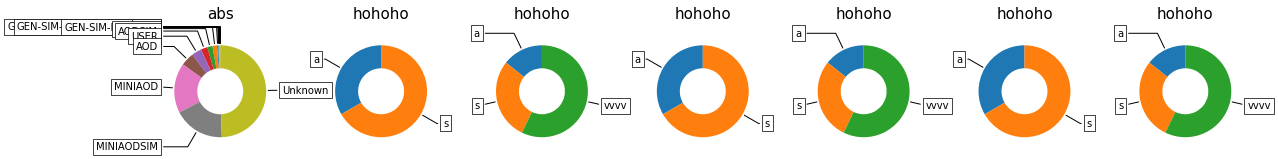

In [145]:
_donut(lst, "ffdsf")

### 3.5 _pie

_pie plots x number of pie charts and saves the figure plotted as a png file. It takes 2 arguments; dictlist: list, figname: string
* dictlist is a list of dict of the needed data that you want to plot. The proper structure of dictlist is as follows:
    * [{ "data field names": [name1, name2, ...], "data values": [value1, value2, ...], "plot name": "name"}, { "data field names": [name1, name2, ...], "data values": [value1, value2, ...], "plot name": "name"}, ...]
    * one dict will be represented as 1 pie chart. You can input many dicts in case you want to plot them side by side.
    * in case of plotting just 1 dict, please do not forget to put it into a list form.
* figname is the name of the figure you want to save it as. The format is .png by default.

In [43]:
def _pie(dictlist: list, figname: str):
    fig, ax = plt.subplots(nrows=1,ncols=len(dictlist), figsize=(10, 10), subplot_kw={'aspect': 'equal'})
    for i in range(len(dictlist)):
        values_lst = list(dictlist[i].values())
        ax[i].pie(values_lst[1], labels=values_lst[0], autopct='%1.1f%%',
            shadow=False, startangle=90)
        ax[i].axis('equal') 
        ax[i].set_title(values_lst[2], fontsize=15)
   
    plt.savefig(figname+".png")
    plt.subplots_adjust(left=0.5,
                        bottom=0.1, 
                        right=2, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    plt.show()


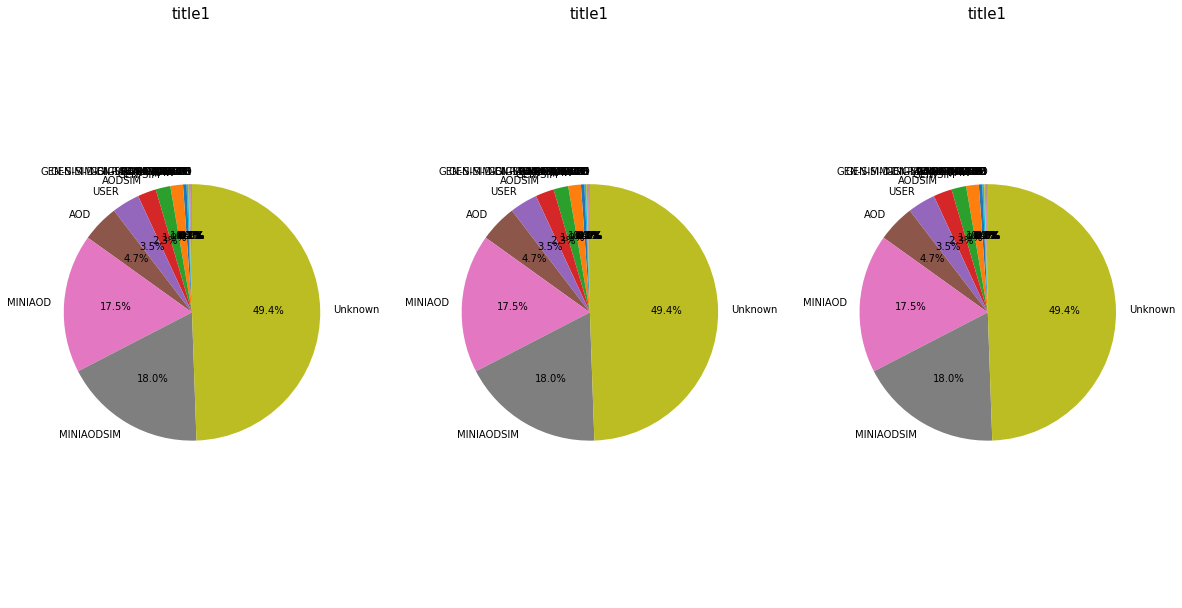

In [44]:
testDf['title'] = "title1"
_pie([testDf,testDf,testDf], "name")

### 3.6 _lines_graph

_lines_graph takes 4 arguments (xvalues: list, dictlist: list, figinfo: dict, figname: str, show_mean: bool) and plots x number of lines. 

* x-axis values is a list of x-axis values. Note that plotting several y lines requires that the x-axis is in the same scale thus only input it 1 time is enough.
    * x-axis values : [x1, x2, ...]
* dictlist is a list of dict of the needed data that you want to plot. The proper structure of dictlist is as follows:
    * [{"y-axis1 values": [y1, y2, ...], "label1": "label", "color1": "color"}, {"y-axis2 values": [y1, y2, ...], "label2": "label", "color2": "color"}, ...]
* figinfo is a dict containing the figure infomation. It can be declared as follows: figinfo  = {"x_label": "this is x-axis","y_label": "this is y-axis","title": "this is plot"}
* figname is a string to be saved into a png file
* show_mean is a bool to select whether you want to plot the mean values of each line.


In [104]:
def _line_graph(xvalues: list, dictlist: list, figinfo: dict, figname: str, show_mean: bool):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    for i in range(len(dictlist)): 
        values_lst = list(dictlist[i].values())
        ax.plot(xvalues, values_lst[0], color=values_lst[2], label=values_lst[1])
        if(show_mean):
            plt.hlines(mean(values_lst[0]), min(xvalues), max(xvalues), linestyles="dashed", colors=values_lst[2])
            ax.text(mean(xvalues),mean(values_lst[0]),'%f' % (mean(values_lst[0])))

    ax.set(xlabel=figinfo["x_label"], ylabel=figinfo["y_label"],
           title=figinfo["title"])
    ax.grid()
    plt.legend()
    plt.savefig(figname+".png")
    plt.show()

Example:

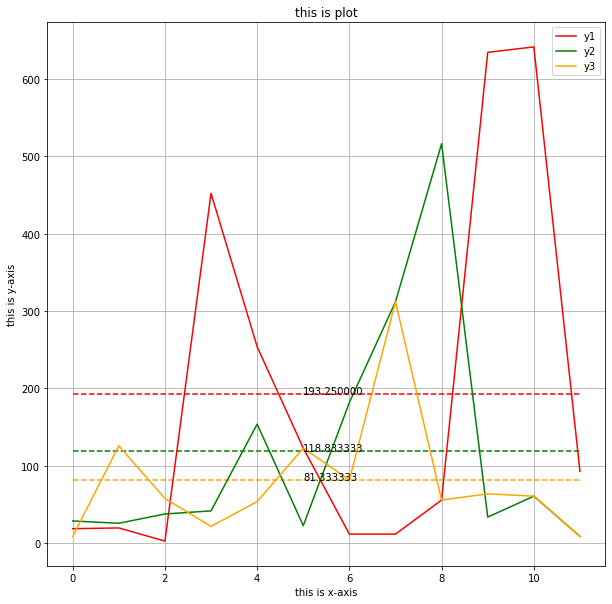

In [105]:
x = np.arange(0, 12, 1)
y1 = [19,20,3,452,254,123,12,12,56,634,641,93]
y2 = [29,26,38,42,154,23,182,312,516,34,61,9]
y3 = [9,126,58,22,54,123,82,312,56,64,61,9]
info = {"x_label": "this is x-axis","y_label": "this is y-axis","title": "this is plot"}
dictlist = [{"one": y1, "label": "y1", "color": "red"}, {"two": y2, "label": "y2", "color": "green"}, {"three": y3, "label": "y3", "color": "orange"}]
_line_graph(x, dictlist, info, "figname", True)

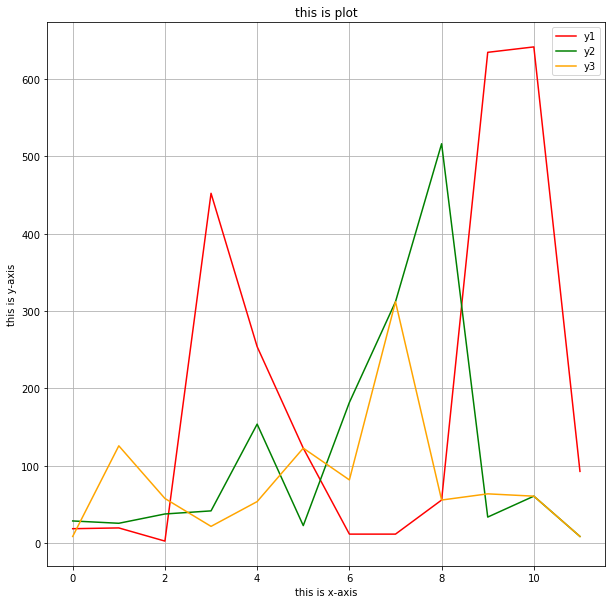

In [106]:
_line_graph(x, dictlist, info, "figname", False)

### 3.7 Table

In [76]:
def _table(pandasDataframe):
    plt.figure(figsize=(10, 4))
    ax = plt.subplot() 
    plt.axis('off')
    tbl = table(ax,pandasDataframe, loc='center')
    tbl.auto_set_font_size(True)

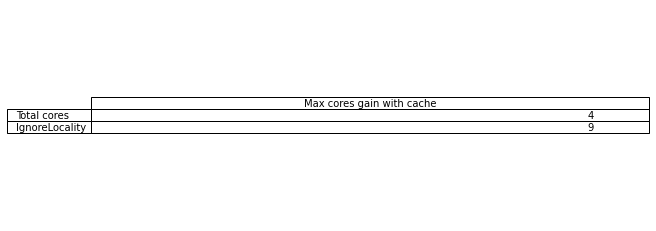

In [77]:
cpu_gain_table = pd.DataFrame({'Max cores gain with cache': [4, 9]},
                               index=["Total cores", "IgnoreLocality"])   
_table(cpu_gain_table)

## Note

##### - If data is  large, consider writing it to Parquet and reading it back directly in Python using PyArrow (Reading and Writing the Apache Parquet Format) completely skipping all the intermediate stages. [Ref](https://stackoverflow.com/questions/47536123/collect-or-topandas-on-a-large-dataframe-in-pyspark-emr)